In [25]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from collections import Counter
from sklearn import metrics 
from itertools import cycle
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD ,PCA
from sklearn.metrics import pairwise_distances , classification_report 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize 
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
import spacy
from sklearn.pipeline import make_pipeline
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Classifying News Articles Unreliable News Articles

The media pokes fun a Donald Trump for shouting “fake news.” On the surface it is a little funny. If we take a hard look, though, “fake news” does present a problem in our society. When media articles are shared as fact and go unchecked the information within could be potentially harmful to the reader. News makes an impact on how people vote, make medical/nutritional decisions, and the products they buy. If the information they are receiving is tainted then this could damage society as a whole. It takes work to fact check an article and many people do not make the effort to do so. If the reader finds the article compelling they share it with their peers and friends. Doing so spreads bad information.


## The Data
In order to produce a model that can classify a news article as either reliable or unreliable we need labeled data. The data that will be used for this task has been downloaded from a Kaggle.com competition and can be found here: https://www.kaggle.com/c/fake-news/data. 
This dataset contains over 20,000 article entries that are labels as potentially unreliable(1) or reliable(0). There is also other included information such as title, author, and article id number.  

In [26]:
# Load the data
fake_news_df = pd.read_csv('C:/Users/keith/Desktop/Thinkful/fakeNEWS.csv')
pd.set_option('display.max_columns', 50)

In [27]:
fake_news_df.shape

(20800, 5)

In [28]:
fake_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
id        20800 non-null int64
title     20242 non-null object
author    18843 non-null object
text      20761 non-null object
label     20800 non-null int64
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [29]:
# convert title author and text to proper formats
fake_news_df['title'] = fake_news_df.title.astype(str)
fake_news_df['text'] = fake_news_df.text.astype(str)
fake_news_df['author'] = fake_news_df.author.astype(str)

In [30]:
# check for null values
fake_news_df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [31]:
fake_news_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [32]:
# Drop NA rows
drop = np.where(fake_news_df.text.isna())[0]
fake_news_df.drop(drop,0,inplace=True)
fake_news_df.index = range(len(fake_news_df))

In [33]:
# Drop duplicated rows
drop = np.where(fake_news_df.text.duplicated())[0]
fake_news_df.drop(drop,0,inplace=True)
fake_news_df.index = range(len(fake_news_df))

In [34]:
print("Duplicated: ",fake_news_df.text.duplicated().sum())
print("Null: ",fake_news_df.text.isna().sum())
print("Shape: ",fake_news_df.shape)

Duplicated:  0
Null:  0
Shape:  (20387, 5)


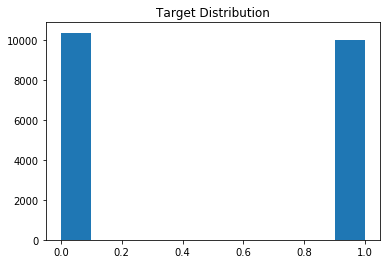

In [35]:
# Plot class distribution
plt.title("Target Distribution")
plt.hist(fake_news_df.label)
plt.show()

The distribution of the classes show that this is a balanced data set. Next, a feature will be created that extracts the word count of each article

In [36]:
fake_news_df['length'] = fake_news_df.text.apply(lambda x: len(x.split()))

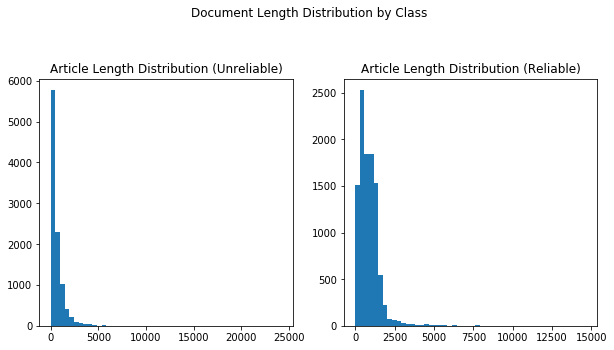

In [37]:
plt.figure(figsize=(10,10))
plt.suptitle("Document Length Distribution by Class")

plt.subplot(221)
plt.hist(fake_news_df[fake_news_df.label==1].length,bins=50)
plt.title("Article Length Distribution (Unreliable)")

plt.subplot(222)
plt.hist(fake_news_df[fake_news_df.label==0].length,bins=50 )
plt.title("Article Length Distribution (Reliable)")
plt.show()

Another length featured will be created from the average sentence length of each article.

In [14]:
fake_news_df['average_sent_length'] = fake_news_df.text.apply(lambda x: np.mean([len(sent) for sent in nlp(x).sents]))    

NameError: name 'nlp' is not defined

AttributeError: 'DataFrame' object has no attribute 'average_sent_length'

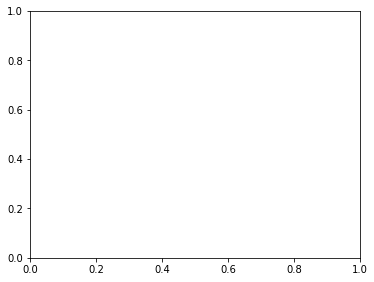

In [38]:
plt.figure(figsize=(13,10))
plt.subplot(221)
plt.boxplot(fake_news_df.average_sent_length)
plt.subplot(222)
plt.hist(fake_news_df.average_sent_length, bins=20)
plt.show()

In [39]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(fake_news_df.average_sent_length))
print(z)
print("Number of outliers is {}".format(len(fake_news_df.average_sent_length.loc[np.where(z>3)])))
np.argsort(np.where(z>3)) 

AttributeError: 'DataFrame' object has no attribute 'average_sent_length'

NameError: name 'z' is not defined

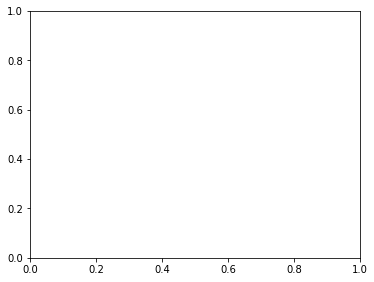

In [40]:
plt.figure(figsize=(13,10))
plt.subplot(221)
plt.boxplot(fake_news_df.loc[np.where(z<3)[0],:].average_sent_length)
plt.subplot(222)
plt.hist(fake_news_df.loc[np.where(z<3)[0],:].average_sent_length, bins=20)
plt.show()

In [ ]:
plt.figure(figsize=(13,10))
plt.suptitle("Document Length Distribution by Class")

plt.subplot(221)
plt.hist(fake_news_df[fake_news_df.label==1].average_sent_length,bins=50)
plt.title("Average Sentence Length Distribution (Unreliable)")

plt.subplot(222)
plt.hist(fake_news_df[fake_news_df.label==0].average_sent_length,bins=50 )
plt.title("Average Sentence Length Distribution (Reliable)")
plt.show()

In [17]:
fake_news_df.head()

,id,title,author,text,label,length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,710
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,557
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,154


In [41]:
# helper functions
nlp = spacy.load('en')

def preprocessing_txt(text):    
    text = re.sub(r"[^a-zA-Z.' ]+", "", text)     
    text  = re.sub(r'\b\w{1}\b', '', text)       
    text = text.lower()
    text = " ".join(text.split())
    text = text    
    return text;

def pos_tagged(text):
    text = nlp(text)
    text = " ".join([word.text+"_"+word.pos_ for word in text                          
                         if  not word.is_punct 
                         and not word.text in stopwords
                         and len(word)>3]) 
    return nlp(text);
def lemmas(text):
    text = nlp(text)
    text = " ".join([word.lemma_ for word in text                          
                         if  not word.is_punct 
                         and not word.text in stopwords
                         and len(word)>3]) 
    return nlp(text);

def vectorizer(vectorizer,text,tokenizer):
    
    if vectorizer == "tfidf":
        
        Vectorizer = TfidfVectorizer(analyzer='word',
                                 tokenizer = tokenizer,
                                 stop_words=stopwords,
                                 ngram_range=(1, 1),
                                 max_df=1.0,
                                 min_df=1,
                                 max_features=2500,
                                 use_idf=True, 
                                 smooth_idf=True)
        
        text = Vectorizer.fit_transform(text)
        
    elif vectorizer == "count":
        
        Vectorizer = CountVectorizer(lowercase=True, 
                              tokenizer = tokenizer,
                              stop_words=stopwords,
                              ngram_range=(1, 1),
                              analyzer='word',
                              max_df=1.0,
                              min_df=1,
                              max_features=2500)
        
        text = Vectorizer.fit_transform(text)           

    return Vectorizer, text;

In [42]:
fake_news_df['clean_text'] = fake_news_df.text.apply(preprocessing_txt)
# fake_news_df['lemmas'] = fake_news_df.text.apply(lambda x: preprocessing_txt("lemmas",x))
# fake_news_df['pos'] = fake_news_df.text.apply(lambda x: preprocessing_txt("pos",x))

In [43]:
# #pickle in
# import pickle

# file = open('BOWtrainTEST9items.pickle', 'rb')

# a,b,c,d,e,f= pickle.load(file)

# file.close()
# file = open('TFIDFFFFFFF.pickle', 'rb')

# n,i,j,k,l,m= pickle.load(file)

# file.close()

In [3]:
f = fake_news_df
# pickle out
pickle_out = open("faaaaake.pickle","wb")
pickle.dump(f,pickle_out)
pickle_out.close()

In [46]:
from sklearn.feature_extraction import text
stopwords = text.ENGLISH_STOP_WORDS

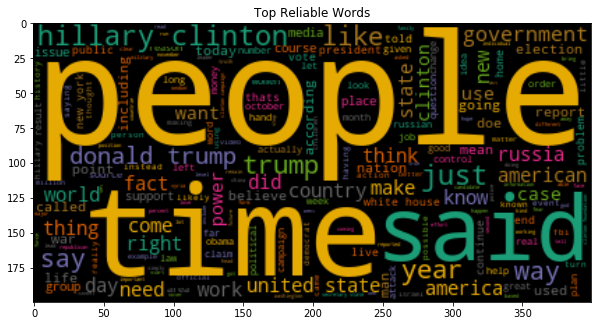

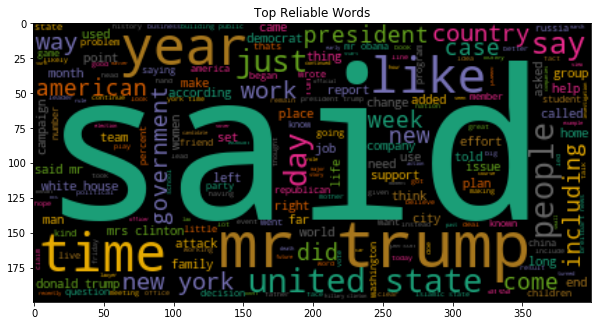

In [47]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.figure(figsize=(10,10))
wc.generate(" ".join(fake_news_df[fake_news_df.label==1].clean_text.values) )
plt.imshow(wc, interpolation="bilinear",)
plt.title("Top Reliable Words")
plt.show() 
plt.figure(figsize=(10,10))
wc.generate(" ".join(fake_news_df[fake_news_df.label==0].clean_text.values) )
plt.imshow(wc, interpolation="bilinear",)
plt.title("Top Reliable Words")
plt.show() 

In [48]:
# separate target
X = fake_news_df 
Y = fake_news_df.label

In [49]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=0)

## Bag of words features

In [50]:
BOW_text, bow_xtrain = vectorizer("count",X_train.clean_text,None)
bow_xtest = BOW_text.transform(X_test.clean_text)

In [51]:
doc_term_matrix = pd.DataFrame(bow_xtrain.toarray(), columns=BOW_text.get_feature_names())
doc_term_matrix['target_label'] = y_train.values
doc_term_matrix

,abedin,ability,able,abortion,abroad,absolutely,abuse,academy,accept,accepted,access,according,account,accounts,accusations,accused,achieve,acknowledged,act,acting,action,actions,active,activist,activists,...,wounded,write,writer,writes,writing,written,wrong,wrote,year,yearold,years,yemen,yes,yesterday,york,youll,young,younger,youre,youtube,youve,zero,zika,zone,target_label
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,2,0,0,0,0,3,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
15286,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
15287,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0
15288,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [52]:
doc_term_matrix = pd.DataFrame(bow_xtrain.toarray(), columns=BOW_text.get_feature_names())
doc_term_matrix['target_labels'] = y_train.values
grouped_term_sum = doc_term_matrix.groupby("target_labels").sum(axis=1).T
grouped_term_sum

target_labels,0,1
abedin,99,611
ability,725,558
able,1550,1321
abortion,555,156
abroad,359,208
...,...,...
youtube,198,475
youve,409,317
zero,242,401
zika,276,297


In [53]:
top_words_dict = {}
for label in grouped_term_sum.columns:
    top_words = grouped_term_sum[label].sort_values(ascending=False)[:300]
    top_words_dict[label] = list(zip(top_words.index,top_words.values))

In [54]:
top_reliable = []
top_unreliable = []

for label, words in top_words_dict.items():
    if label==0:
        print("Top Reliable words: \n")
        top_reliable.append(", ".join([word for (word, count) in words]))
        print(", ".join(top_reliable))
    if label==1:
        print("Top Unreliable words: \n")
        top_unreliable.append(", ".join([word for (word, count) in words]))
        print(", ".join(top_unreliable))     

Top Reliable words: 

said, mr, trump, new, people, like, president, ms, years, time, states, just, state, united, year, news, did, american, trumps, house, government, going, say, white, make, percent, campaign, told, think, dont, way, officials, clinton, national, day, police, york, work, including, times, according, world, obama, know, political, country, public, want, law, twitter, called, city, million, week, republican, media, security, long, administration, group, federal, party, company, donald, mrs, good, court, home, right, family, im, office, health, later, election, women, life, washington, added, school, case, thats, days, department, asked, took, used, help, come, use, left, man, support, members, university, wrote, business, policy, statement, came, recent, chief, really, need, little, black, team, breitbart, does, executive, far, money, saying, children, night, place, care, republicans, general, dr, military, end, war, director, north, months, change, things, set, big, 

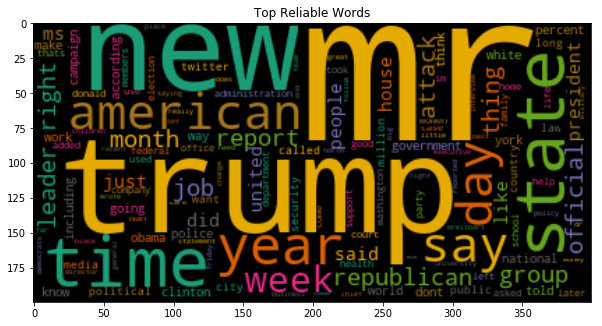

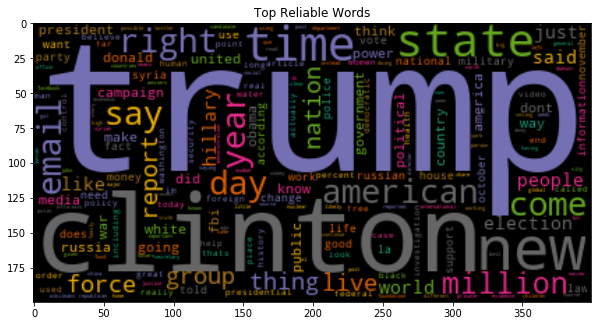

In [55]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.figure(figsize=(10,10))
wc.generate(" ".join(top_reliable))
plt.imshow(wc, interpolation="bilinear",)
plt.title("Top Reliable Words")
plt.show() 
plt.figure(figsize=(10,10))
wc.generate(" ".join(top_unreliable))
plt.imshow(wc, interpolation="bilinear",)
plt.title("Top Reliable Words")
plt.show() 

In [56]:
tops = []
for label in grouped_term_sum.columns:
    words = grouped_term_sum[label].sort_values(ascending=False)[:300].index
    for w in words:
        tops.append(w)

In [57]:
new_stop_words = []
common_words = dict(Counter(tops).most_common())
for stop, count in common_words.items():
    if count>1:
        new_stop_words.append(stop)


In [58]:
from sklearn.feature_extraction import text
stopwords = text.ENGLISH_STOP_WORDS.union(new_stop_words)


In [59]:
 
# pickle out
pickle_out = open("STOPWORDS.pickle","wb")
pickle.dump(stopwords,pickle_out)
pickle_out.close()

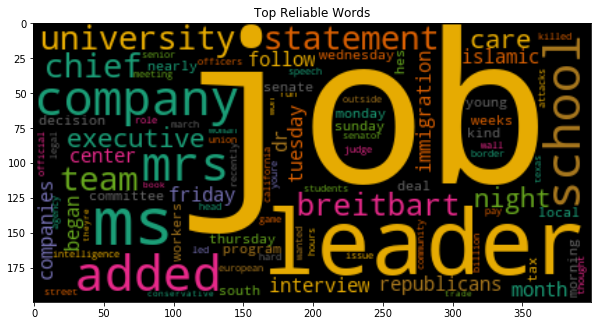

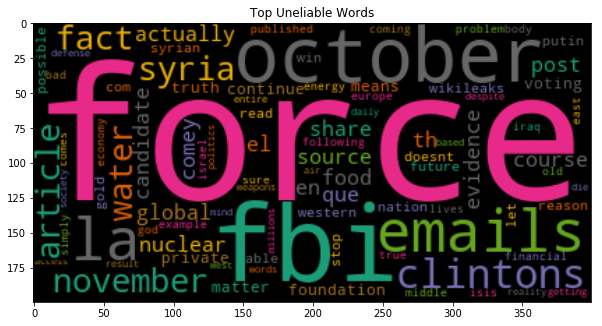

In [60]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.figure(figsize=(10,10))
wc.generate(" ".join(top_reliable))
plt.imshow(wc, interpolation="bilinear",)
plt.title("Top Reliable Words")
plt.show() 
plt.figure(figsize=(10,10))
wc.generate(" ".join(top_unreliable))
plt.imshow(wc, interpolation="bilinear",)
plt.title("Top Uneliable Words")
plt.show() 

In [61]:
BOW, bow_xtrain_text = vectorizer("count",X_train.clean_text,None)  
bow_xtest_text = BOW.transform(X_test.clean_text) 

In [62]:
BOW_lemma, bow_xtrain_lemmas = vectorizer("count",X_train.clean_text,lemmas) 
bow_xtest_lemmas = BOW.transform(X_test.clean_text)

In [63]:
BOW_pos, bow_xtrain_pos = vectorizer("count",X_train.clean_text,pos_tagged) 
bow_xtest_pos = BOW_pos.transform(X_test.clean_text)

In [65]:
# pickle out
pickle_out = open("bow_xtrain_text.pickle","wb")
pickle.dump(bow_xtrain_text,pickle_out)
pickle_out.close()
# pickle out
pickle_out = open("bow_xtest_text.pickle","wb")
pickle.dump(bow_xtest_text,pickle_out)
pickle_out.close()

pickle_out = open("bow_xtest_lemmas.pickle","wb")
pickle.dump(bow_xtest_lemmas,pickle_out)
pickle_out.close()
# pickle out
pickle_out = open("bow_xtrain_lemmas.pickle","wb")
pickle.dump(bow_xtrain_lemmas,pickle_out)
pickle_out.close()
# pickle out
pickle_out = open("bow_xtrain_pos.pickle","wb")
pickle.dump(bow_xtrain_pos,pickle_out)
pickle_out.close()
# pickle out
pickle_out = open("bow_xtest_pos.pickle","wb")
pickle.dump(bow_xtest_pos,pickle_out)
pickle_out.close()
# pickle out
 

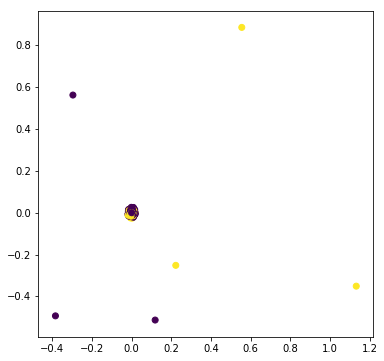

In [91]:
svd = TruncatedSVD(2)
bow_svd = svd.fit_transform(bow_xtrain_lemmas.toarray())
plt.figure(figsize=(6,6))
plt.scatter(bow_svd[:,0],bow_svd[:,1],c=y_train)


plt.show()

In [77]:
lr = LogisticRegression(solver='lbfgs', penalty='l2', C=.001)
def train_eval(model,data):    
    model.fit(data,y_train)
    print(model.score(data,y_train))
    return;


train_eval(lr,bow_xtrain_tpos.toarray())
# train_eval(lr,bow_xtrain_pos.toarray())
# train_eval(lr,bow_xtrain_t.toarray())

 

NameError: name 'bow_xtrain_tpos' is not defined

In [92]:
lr.fit(bow_xtrain_pos,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr.score(bow_xtest_l.toarray(),y_test)

In [85]:
type(BOW_lemma.get_feature_names())

list

In [94]:
LR_coeff_df = { 'Features': [i.text for i in BOW_pos.get_feature_names()],'Coefficients': lr.coef_[0]}
LR_coeff_df = pd.DataFrame(data=LR_coeff_df, index=range(len(BOW_pos.get_feature_names())))
print('First 15 Coefficients')
LR_coeff_df = LR_coeff_df.sort_values(by='Coefficients',ascending=False).sort_values(by='Coefficients',ascending=False)
LR_coeff_df.index = range(len(LR_coeff_df))

First 15 Coefficients


In [ ]:
LR_coeff_df[:15]

## Tfidf features

<img src="img131.gif">

In [97]:
TFIDF_vec, X_train_tfidf_text = vectorizer("tfidf",X_train.clean_text,None)
X_test_tfidf_text = TFIDF_vec.transform(X_test.clean_text)

In [98]:
TFIDF_vec_pos, X_train_tfidf_pos = vectorizer("tfidf",X_train.clean_text,pos_tagged)
X_test_tfidf_pos = TFIDF_vec_pos.transform(X_test.clean_text)

In [63]:
TFIDF_vec_lemmas ,X_train_tfidf_lemmas = vectorizer("tfidf",X_train.clean_text,lemmas)
X_test_tfidf_lemmas = TFIDF_vec_lemmas.transform(X_test.clean_text)

In [99]:

pickle_out = open("X_train_tfidf_text.pickle","wb")
pickle.dump(X_train_tfidf_text,pickle_out)
pickle_out.close()

pickle_out = open("X_test_tfidf_text.pickle","wb")
pickle.dump(X_test_tfidf_text,pickle_out)
pickle_out.close()

pickle_out = open("X_train_tfidf_pos.pickle","wb")
pickle.dump(X_train_tfidf_pos,pickle_out)
pickle_out.close()

pickle_out = open("X_test_tfidf_pos.pickle","wb")
pickle.dump(X_test_tfidf_pos,pickle_out)
pickle_out.close()

pickle_out = open("X_train_tfidf_lemmas.pickle","wb")
pickle.dump(X_train_tfidf_lemmas,pickle_out)
pickle_out.close()

pickle_out = open("X_test_tfidf_lemmas.pickle","wb")
pickle.dump(X_test_tfidf_lemmas,pickle_out)
pickle_out.close()
 

NameError: name 'X_train_tfidf_lemmas' is not defined

In [333]:
lr.fit(X_train_tfidf_P,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [334]:
LR_coeff_df = { 'Features': Vectorizer.get_feature_names(),'Coefficients': lr.coef_[0]}
LR_coeff_df = pd.DataFrame(data=LR_coeff_df, index=range(len(Vectorizer.get_feature_names())))
print('First 15 Coefficients')
LR_coeff_df = LR_coeff_df.sort_values(by='Coefficients',ascending=False).sort_values(by='Coefficients',ascending=False)
LR_coeff_df.index = range(len(LR_coeff_df))

First 15 Coefficients


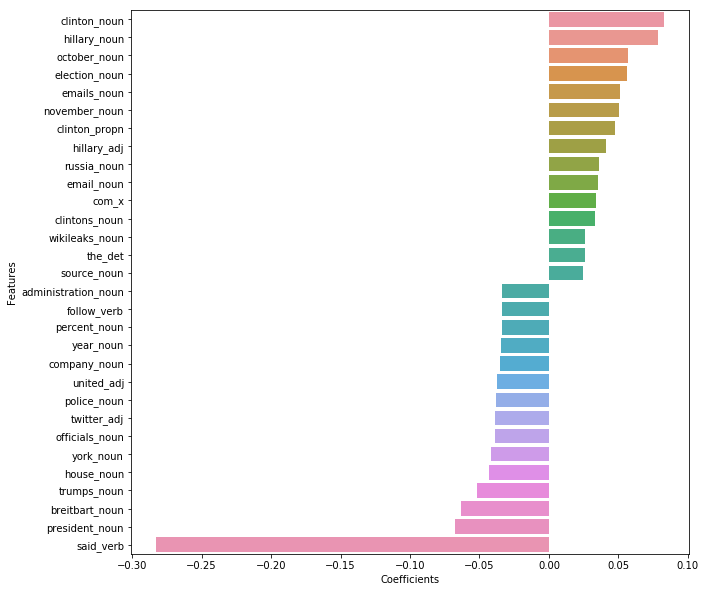

In [335]:
plt.figure(figsize=(10,10))
sns.barplot(x="Coefficients",y='Features', data=LR_coeff_df.iloc[np.r_[:15, (2500-15):2500],:])
plt.show() 

## Latent Samantic Analysis on tfidf
It is possible that reliable and unreliable documents share similar will be more similar to each other in their respective categories. We can use LSA on a tfidf matrix and then multipy that matix my its transpose so that each document vector is being mulitplied by every other vecotor in the set. Since the matirix is normalized this will produce an approximate cosine similarity matrix where we can test the hypothesis. 

In [103]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(30)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa_text = lsa.fit_transform(X_train_tfidf_text)

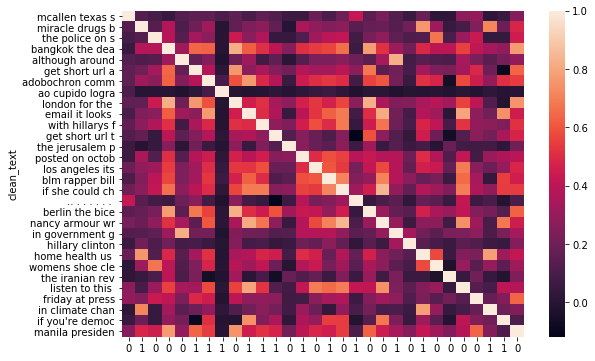

In [110]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa_text) * np.asmatrix(X_train_lsa_text).T)
sim_matrix=pd.DataFrame(similarity,index=X_train.clean_text).iloc[0:30,0:30]
plt.figure(figsize=(9,6))
ax = sns.heatmap(sim_matrix,xticklabels=y_train[:30],yticklabels=[x[:15] for x in X_train.clean_text[:30]])
plt.show()


In [111]:
sim_df = pd.DataFrame(similarity)
sim_df['labels'] = y_train.values

In [112]:
# average the unreliable columns
average_sim = sim_df[sim_df.labels==1].drop('labels',1).mean(axis=0).values.copy()

In [113]:
X_train['average_sim'] = average_sim

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


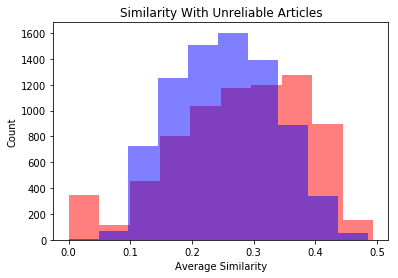

In [122]:
plt.hist(X_train[X_train.label==1].average_sim,alpha=.5, color='red')
plt.hist(X_train[X_train.label==0].average_sim,alpha=.5,color='blue')
plt.title("Similarity With Unreliable Articles")
plt.xlabel('Average Similarity')
plt.ylabel('Count')
plt.show()

In [124]:
# confirm with T-test
print(stats.ttest_ind(
                X_train[X_train.label==0].average_sim, 
                X_train[X_train.label==1].average_sim  
            ))

Ttest_indResult(statistic=-15.01322700836417, pvalue=1.379409281170655e-50)


## Non-negative Matrix Factorization
Here we will create a feature by using NNMF to model topics and then use the probabilities that a document belongs to a certain topic to group the documents. That grouping will then be used as a predictive feature.

In [125]:
from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=20, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )


In [126]:
X_train_nnmf = nmf.fit_transform(X_train_tfidf_text)  
X_test_nnmf = nmf.transform(X_test_tfidf_text)  

Let's take a look at the topics and see if they make sense. This will give a generally idea if the algorithim is working the way we expect.

In [130]:
for index ,topic in enumerate(nmf.components_):
    print(index)
    print([TFIDF_vec.get_feature_names()[i]for i in topic.argsort()[-30:]])

0
['words', 'mean', 'young', 'stories', 'watch', 'fact', 'talk', 'maybe', 'mind', 'true', 'star', 'let', 'truth', 'night', 'read', 'thought', 'tell', 'theyre', 'old', 'actually', 'kind', 'woman', 'ive', 'god', 'doesnt', 'film', 'youre', 'hes', 'book', 'love']
1
['sent', 'investigators', 'announcement', 'investigating', 'scandal', 'foundation', 'discovered', 'decision', 'private', 'investigations', 'bureau', 'october', 'criminal', 'attorney', 'lynch', 'evidence', 'anthony', 'agents', 'huma', 'classified', 'abedin', 'letter', 'clintons', 'server', 'comeys', 'weiner', 'james', 'emails', 'comey', 'fbi']
2
['aircraft', 'turkey', 'allies', 'missiles', 'zone', 'iraq', 'conflict', 'korea', 'saudi', 'russians', 'air', 'regime', 'western', 'civilians', 'defense', 'chemical', 'moscow', 'rebels', 'russias', 'missile', 'forces', 'nato', 'iran', 'weapons', 'assad', 'nuclear', 'putin', 'aleppo', 'syrian', 'syria']
3
['night', 'moved', 'center', 'recalled', 'sister', 'manhattan', 'film', 'lawyer', 'ma

In [131]:
X_train['nmf_topics'] = X_train_nnmf.argmax(axis=1)
X_test['nmf_topics'] = X_test_nnmf.argmax(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Word2Vec features

In order to produce the word embeddings from word2vec the data has to be tokenized into sentences. In this case, since we are classifying documents and not sentences, each document will be treated like one long sentence.

In [134]:
from gensim.models import word2vec

In [135]:
model = gensim.models.KeyedVectors.load_word2vec_format ('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
# convert data into input that W2V likes.
sentences_pos = []
for article in X_train.clean_text:     
    sentences_pos.append([ word.text+"_"+word.pos_ for word in nlp(article) if not word.text in stopwords])     

In [ ]:
#pickle in
import pickle

file = open('W2VPOS.pickle', 'rb')

sentences_pos = pickle.load(file)

file.close()

In [ ]:
# # pickle out
# pickle_out = open("W2VPOS.pickle","wb")
# pickle.dump(sentences_pos,pickle_out)
# pickle_out.close()

In [ ]:
# 
news2vec = word2vec.Word2Vec(
    sentences_pos,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=10,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)
print('done!')

In [22]:
# news2vec.wv.save_word2vec_format('POSW2V.bin', binary=True)
news2vec = gensim.models.KeyedVectors.load_word2vec_format('POSW2V.bin',binary=True)  

In [31]:
wvs = dict(zip(model.index2word,model[model.index2word]))

In [32]:
mean_vects = {}
for i ,k in wvs.items():
    mean_vects[i]=np.mean(k)

In [36]:
vector = np.mean([ mean_vects[word.text]  for word in nlp(fake_news_df.clean_text[0]) if word.text in list(mean_vects.keys())])

In [136]:
def doc_vecs(model,df,feature):
    doc_vecs = pd.DataFrame()
    for k, i in enumerate(df.index):
       
        text = nlp(df[feature][i])
        words = [word.text for word in text if word.text in model.index2word]
        if len(words)>0:             
            doc_vecs.loc[:,X_train.clean_text[i]] = np.mean(model[words],axis=0) 
        else:
            doc_vecs[i] = 0
            
    doc_vecs.columns=df[feature] 
    
    return doc_vecs;
    

In [ ]:
W2V_doc = doc_vecs(model,X_train,"clean_text")

## Doc2Vec features


In [ ]:
taged_docs = [TaggedDocument(words=str(nlp(_d)).split() , tags=[str(i)]) for i, _d in enumerate(fake_news_df.clean_text.values)]

In [ ]:
D2V = Doc2Vec(vector_size=300,
                alpha=.025, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tags)

In [ ]:
W2V_doc = doc_vecs(D2V,X_train,"clean_text")

In [ ]:
from sklearn.naive_bayes import BernoulliNB 
bnb = BernoulliNB()
lr = r = LogisticRegression( solver='liblinear',class_weight='balanced')
rfc = ensemble.RandomForestClassifier(n_jobs=-1,n_estimators=10,class_weight='balanced',random_state=20)
clf = ensemble.GradientBoostingClassifier(n_estimators=500,max_depth=2,loss='deviance')
lasso = lr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=50,C=alpha, warm_start=True)
svm = SVC(kernel = 'rbf')

In [ ]:
def train_test_scores(model,train_data,test_data):    
    model.fit(data,y_train)
    train = model.score(train_data,y_train)
    test = model.score(test_data,y_test)
    return train test;
# define a function to extract best params from GridsearchCV
from sklearn.model_selection import GridSearchCV
def best_params(model, X_train , y_train, param_grid):    
    grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', return_train_score=True,verbose=1,n_jobs=-2)
    grid.fit(X_train , y_train)
    print(grid.best_params_)
    print(grid.best_score_)
    return grid.best_params_;

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))